In [1]:
import numpy as np
import pandas as pd
from packaging import version
from collections import Counter
import random

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error as MSE
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, BatchNormalization, Dropout, Flatten, Dense
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical
import tensorflow.keras.backend as k
# from tensorflow.keras.optimizers.legacy import Adam

from tensorflow.python.client import device_lib

In [2]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [3]:
%matplotlib inline
np.set_printoptions(precision=3, suppress=True)

In [4]:
print("This notebook requires TensorFlow 2.0 or above")
print("TensorFlow version: ", tf.__version__)
assert version.parse(tf.__version__).release[0] >=2

This notebook requires TensorFlow 2.0 or above
TensorFlow version:  2.9.1


In [5]:
print("Keras version: ", keras.__version__)

Keras version:  2.9.0


In [6]:
from tensorflow.python.client import device_lib
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [7]:
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 11370849176757678537
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 5750390784
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 10864888110982921042
 physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3060 Ti, pci bus id: 0000:01:00.0, compute capability: 8.6"
 xla_global_id: 416903419]

In [8]:
tf.test.is_built_with_cuda()

True

In [9]:
seed_val = 43

# The below is necessary for starting Numpy generated random numbers
# in a well-defined initial state.
np.random.seed(seed_val)

# The below is necessary for starting core Python generated random numbers
# in a well-defined state.
random.seed(seed_val)

# The below set_seed() will make random number generation
# in the TensorFlow backend have a well-defined initial state.
# For further details, see:
# https://www.tensorflow.org/api_docs/python/tf/random/set_seed
tf.random.set_seed(seed_val)

## EDA Functions

In [10]:
def get_three_classes(x, y):
    def indices_of(class_id):
        indices, _ = np.where(y == float(class_id))
        return indices

    indices = np.concatenate([indices_of(0), indices_of(1), indices_of(2)], axis=0)
    
    x = x[indices]
    y = y[indices]
    
    count = x.shape[0]
    indices = np.random.choice(range(count), count, replace=False)
    
    x = x[indices]
    y = y[indices]
    
    y = tf.keras.utils.to_categorical(y)
    
    return x, y

In [11]:
def show_random_examples(x, y, p):
    indices = np.random.choice(range(x.shape[0]), 10, replace=False)
    
    x = x[indices]
    y = y[indices]
    p = p[indices]
    
    plt.figure(figsize=(10, 5))
    for i in range(10):
        plt.subplot(2, 5, i + 1)
        plt.imshow(x[i])
        plt.xticks([])
        plt.yticks([])
        col = 'green' if np.argmax(y[i]) == np.argmax(p[i]) else 'red'
        plt.xlabel(class_names_preview[np.argmax(p[i])], color=col)
    plt.show()

## Research Assignment Reporting Functions

In [12]:
def plot_history(history):
  losses = history.history['loss']
  accs = history.history['accuracy']
  val_losses = history.history['val_loss']
  val_accs = history.history['val_accuracy']
  epochs = len(losses)

  plt.figure(figsize=(16, 4))
  for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
  plt.show()

def display_training_curves(training, validation, title, subplot):
  ax = plt.subplot(subplot)
  ax.plot(training)
  ax.plot(validation)
  ax.set_title('model '+ title)
  ax.set_ylabel(title)
  ax.set_xlabel('epoch')
  ax.legend(['training', 'validation'])

def print_validation_report(y_test, predictions):
    print("Classification Report")
    print(classification_report(y_test, predictions))
    print('Accuracy Score: {}'.format(accuracy_score(y_test, predictions)))
    print('Root Mean Square Error: {}'.format(np.sqrt(MSE(y_test, predictions)))) 
    
def plot_confusion_matrix(y_true, y_pred):
    mtx = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(16,12))
    sns.heatmap(mtx, annot=True, fmt='d', linewidths=.75,  cbar=False, ax=ax,cmap='Blues',linecolor='white')
    #  square=True,
    plt.ylabel('true label')
    plt.xlabel('predicted label')

## Load Data

In [13]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

## EDA

In [14]:
print('train_images:\t{}'.format(x_train.shape))
print('train_labels:\t{}'.format(y_train.shape))
print('test_images:\t\t{}'.format(x_test.shape))
print('test_labels:\t\t{}'.format(y_test.shape))

train_images:	(50000, 32, 32, 3)
train_labels:	(50000, 1)
test_images:		(10000, 32, 32, 3)
test_labels:		(10000, 1)


In [15]:
print("First ten labels training dataset:\n {}\n".format(y_train[0:10]))
print("This output the numeric label, need to convert to item description")

First ten labels training dataset:
 [[6]
 [9]
 [9]
 [4]
 [1]
 [1]
 [2]
 [7]
 [8]
 [3]]

This output the numeric label, need to convert to item description


In [16]:
(train_images, train_labels),(test_images, test_labels)= tf.keras.datasets.cifar10.load_data()

In [17]:
x_preview, y_preview = get_three_classes(train_images, train_labels)
x_preview, y_preview = get_three_classes(test_images, test_labels)

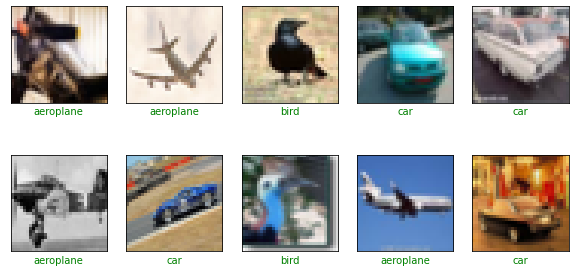

In [18]:
class_names_preview = ['aeroplane', 'car', 'bird']

show_random_examples(x_preview, y_preview, y_preview)

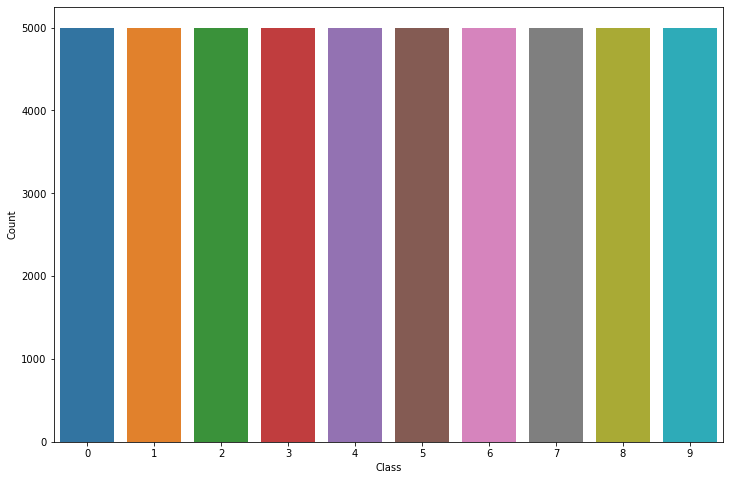

In [19]:
plt.figure(figsize = (12 ,8))
items = [{'Class': x, 'Count': y} for x, y in Counter(train_labels.ravel()).items()]
distribution = pd.DataFrame(items).sort_values(['Class'])
sns.barplot(x=distribution.Class, y=distribution.Count);

In [20]:
class_names = ['airplane'
,'automobile'
,'bird'
,'cat'
,'deer'
,'dog'
,'frog' 
,'horse'
,'ship'
,'truck']

## Create Validation Data Set

In [21]:
x_train_split, x_valid_split, y_train_split, y_valid_split = train_test_split(x_train
                                                                              ,y_train
                                                                              ,test_size=.1
                                                                              ,random_state=seed_val
                                                                              ,shuffle=True)

## Confirm Datasets {Train, Validation, Test}

In [22]:
print(x_train_split.shape, x_valid_split.shape, x_test.shape)

(45000, 32, 32, 3) (5000, 32, 32, 3) (10000, 32, 32, 3)


## Rescale Examples  {Train, Validation, Test}
The images are 28x28 NumPy arrays, with pixel values ranging from 0 to 255
 

1. Each element in each example is a pixel value
2. Pixel values range from 0 to 255
3. 0 = black
4. 255 = white

In [23]:
x_train_norm = x_train_split/255
x_valid_norm = x_valid_split/255
x_test_norm = x_test/255

# STOP SETUP HERE

## Experiment 1

- DNN with 2 layers
- no regularization

In [26]:
k.clear_session()
model_01 = Sequential([
  Flatten(input_shape=x_train_norm.shape[1:]),
  Dense(units=384,activation=tf.nn.relu),
  Dense(units=768,activation=tf.nn.relu),
  Dense(units=10, activation=tf.nn.softmax)       
])

In [27]:
model_01.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 3072)              0         
                                                                 
 dense (Dense)               (None, 384)               1180032   
                                                                 
 dense_1 (Dense)             (None, 768)               295680    
                                                                 
 dense_2 (Dense)             (None, 10)                7690      
                                                                 
Total params: 1,483,402
Trainable params: 1,483,402
Non-trainable params: 0
_________________________________________________________________


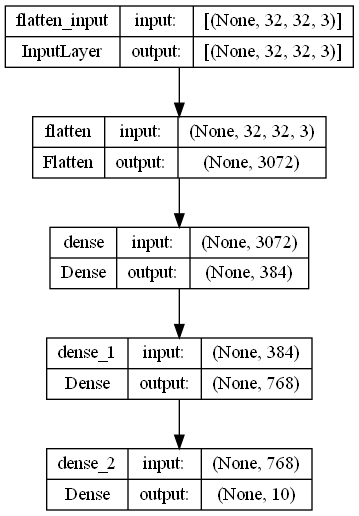

In [28]:
keras.utils.plot_model(model_01, "CIFAR10_EXP_01.png", show_shapes=True) 

In [29]:
model_01.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [30]:
history_01 = model_01.fit(x_train_norm
                    ,y_train_split
                    ,epochs=200
                    ,batch_size=64
                    ,verbose=1
                    ,validation_data=(x_valid_norm, y_valid_split)
                    ,callbacks=[
                     tf.keras.callbacks.ModelCheckpoint("A2_Exp_01_2DNN.h5",save_best_only=True,save_weights_only=False) 
                     ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=7),
                    ]                                                                                                           
                   )

Epoch 1/200
704/704 [==============================] - 8s 5ms/step - loss: 1.8671 - accuracy: 0.3233 - val_loss: 1.7718 - val_accuracy: 0.3572
Epoch 2/200
704/704 [==============================] - 4s 6ms/step - loss: 1.6810 - accuracy: 0.3970 - val_loss: 1.6528 - val_accuracy: 0.4104
Epoch 3/200
704/704 [==============================] - 4s 6ms/step - loss: 1.5968 - accuracy: 0.4283 - val_loss: 1.6330 - val_accuracy: 0.4108
Epoch 4/200
704/704 [==============================] - 3s 4ms/step - loss: 1.5324 - accuracy: 0.4522 - val_loss: 1.5819 - val_accuracy: 0.4398
Epoch 5/200
704/704 [==============================] - 3s 4ms/step - loss: 1.4936 - accuracy: 0.4692 - val_loss: 1.5455 - val_accuracy: 0.4520
Epoch 6/200
704/704 [==============================] - 3s 4ms/step - loss: 1.4604 - accuracy: 0.4780 - val_loss: 1.5253 - val_accuracy: 0.4632
Epoch 7/200
704/704 [==============================] - 3s 4ms/step - loss: 1.4287 - accuracy: 0.4893 - val_loss: 1.5601 - val_accuracy: 0.4568

In [31]:
model_01 = tf.keras.models.load_model("A2_Exp_01_2DNN.h5")
print(f"Test acc: {model_01.evaluate(x_test_norm, y_test)[1]:.3f}")

313/313 [==============================] - 1s 4ms/step - loss: 1.4443 - accuracy: 0.4887
Test acc: 0.489


In [39]:
pred01 = model_01.predict(x_test_norm)
print('shape of preds: ', pred01.shape)

313/313 [==============================] - 1s 2ms/step
shape of preds:  (10000, 10)


In [40]:
history_01_dict = history_01.history
history_01_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [41]:
history__01_df=pd.DataFrame(history_01_dict)
history__01_df.tail().round(3)

,loss,accuracy,val_loss,val_accuracy
23,1.145,0.589,1.586,0.478
24,1.134,0.596,1.605,0.481
25,1.121,0.598,1.604,0.473
26,1.110,0.600,1.581,0.485
27,1.096,0.603,1.601,0.480


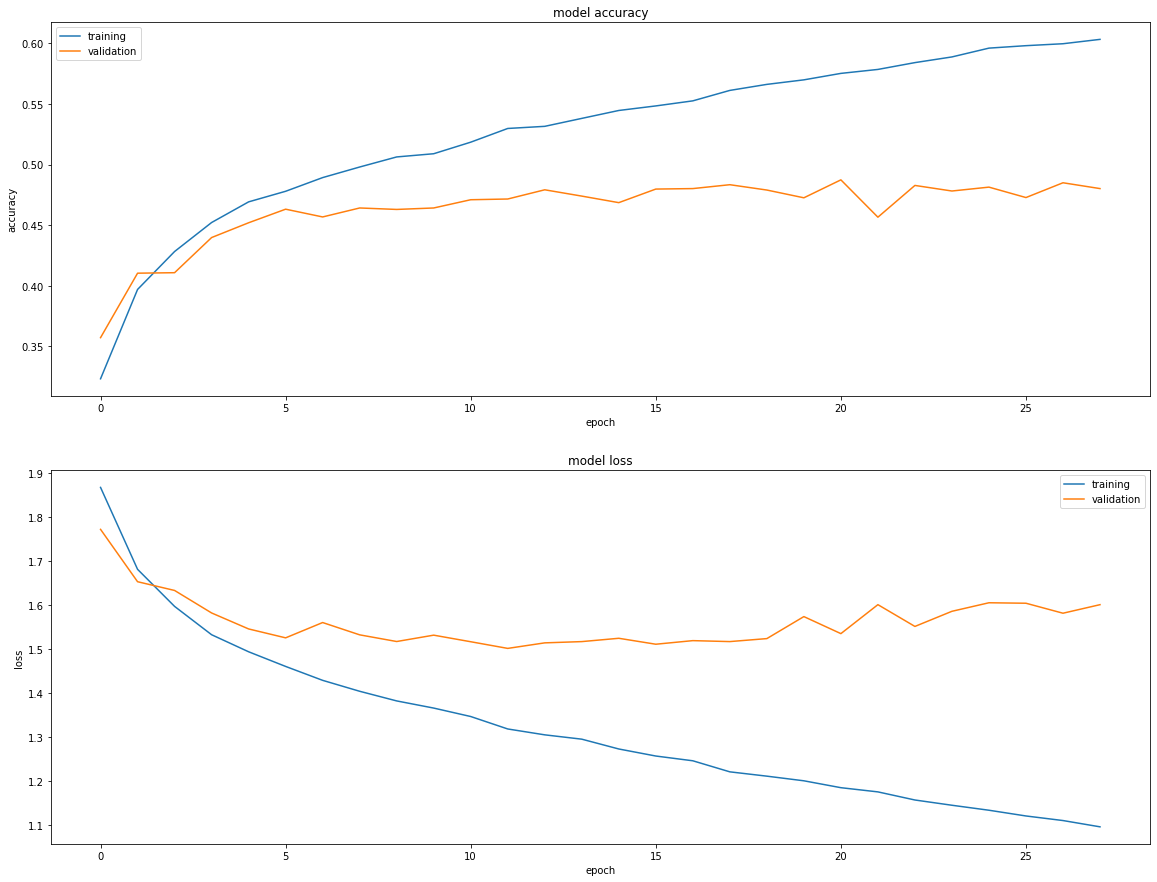

In [42]:
plt.subplots(figsize=(16,12))
plt.tight_layout()
display_training_curves(history_01.history['accuracy'], history_01.history['val_accuracy'], 'accuracy', 211)
display_training_curves(history_01.history['loss'], history_01.history['val_loss'], 'loss', 212)

In [43]:
pred01_cm=np.argmax(pred01, axis=1)
print_validation_report(y_test, pred01_cm)

Classification Report
              precision    recall  f1-score   support

           0       0.51      0.64      0.57      1000
           1       0.60      0.65      0.63      1000
           2       0.35      0.39      0.37      1000
           3       0.32      0.40      0.35      1000
           4       0.46      0.33      0.39      1000
           5       0.45      0.32      0.38      1000
           6       0.56      0.49      0.52      1000
           7       0.46      0.64      0.54      1000
           8       0.64      0.56      0.60      1000
           9       0.61      0.47      0.53      1000

    accuracy                           0.49     10000
   macro avg       0.50      0.49      0.49     10000
weighted avg       0.50      0.49      0.49     10000

Accuracy Score: 0.4887
Root Mean Square Error: 3.1143538655714766


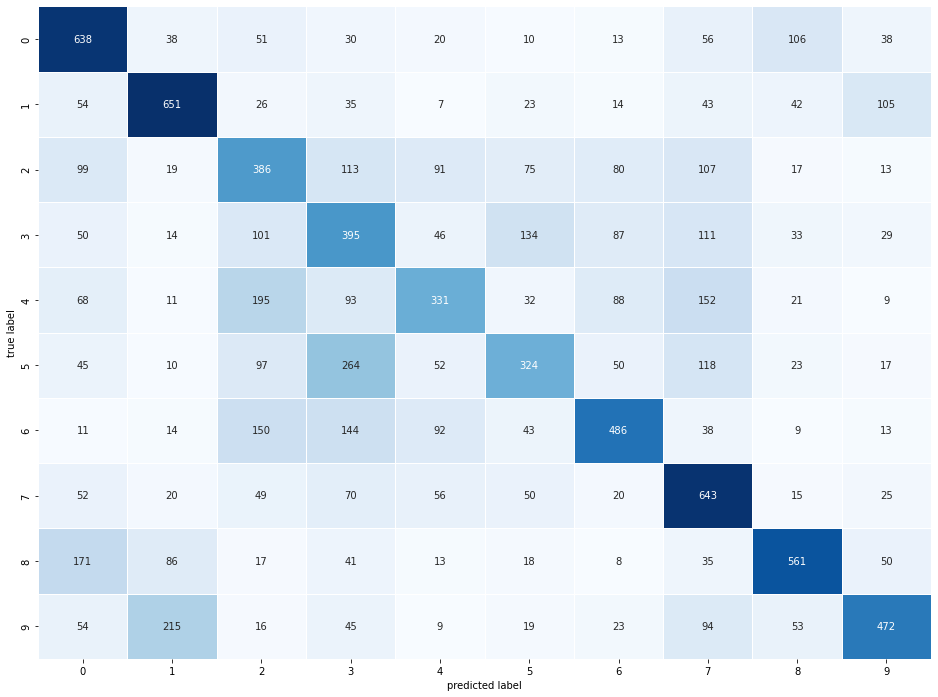

In [44]:
plot_confusion_matrix(y_test,pred01_cm)

In [45]:
cm = sns.light_palette((260, 75, 60), input="husl", as_cmap=True)
df = pd.DataFrame(pred01[0:20], columns = ['airplane'
                                          ,'automobile'
                                          ,'bird'
                                          ,'cat'
                                          ,'deer'
                                          ,'dog'
                                          ,'frog'
                                          ,'horse'
                                          ,'ship'
                                          ,'truck'])
df.style.format("{:.2%}").background_gradient(cmap=cm)

,airplane,automobile,bird,cat,deer,dog,frog,horse,ship,truck
0,1.43%,16.02%,0.52%,40.29%,13.87%,16.35%,0.05%,1.14%,5.14%,5.19%
1,19.81%,20.56%,0.39%,0.13%,0.01%,0.05%,0.02%,0.10%,11.84%,47.11%
2,34.39%,28.62%,0.12%,0.29%,0.06%,0.10%,0.00%,1.06%,22.08%,13.27%
3,20.41%,16.53%,4.62%,3.40%,5.73%,1.52%,0.05%,15.25%,21.78%,10.71%
4,0.20%,0.06%,6.34%,4.64%,72.91%,2.70%,12.31%,0.63%,0.17%,0.03%
5,1.72%,0.45%,13.02%,16.68%,13.26%,6.12%,44.31%,3.78%,0.17%,0.47%
6,42.91%,16.95%,4.90%,9.72%,0.07%,20.10%,0.09%,2.04%,2.92%,0.30%
7,0.43%,0.08%,44.64%,9.14%,16.91%,7.71%,18.52%,2.26%,0.06%,0.26%
8,5.59%,0.40%,30.42%,13.49%,16.04%,18.62%,3.29%,10.59%,0.87%,0.70%
9,3.53%,68.82%,0.17%,1.24%,0.10%,0.21%,0.00%,0.41%,1.34%,24.17%


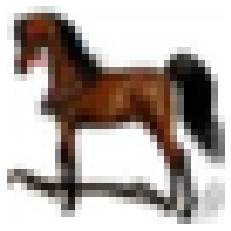

In [46]:
(_,_), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()

img = test_images[2004]
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)

class_names = ['airplane'
,'automobile'
,'bird'
,'cat'
,'deer'
,'dog'
,'frog' 
,'horse'
,'ship'
,'truck']

plt.imshow(img, cmap='viridis')
plt.axis('off')
plt.show()

In [47]:
# Extracts the outputs of the top 8 layers:
layer_outputs = [layer.output for layer in model_01.layers[:8]]
# Creates a model that will return these outputs, given the model input:
activation_model_01 = tf.keras.models.Model(inputs=model_01.input, outputs=layer_outputs)

# Get activation values for the last dense layer
# activations_01 = activation_model_01.predict(x_valid_norm[:3250])
activations_01 = activation_model_01.predict(x_valid_norm[:2000])
dense_layer_activations_01 = activations_01[-3]
output_layer_activations_01 = activations_01[-1]

63/63 [==============================] - 0s 2ms/step


In [48]:
# Reduce the dimension using T-SNE to visualize i n a scatterplot
tsne_01 = TSNE(n_components=2, verbose=1, init='pca', learning_rate='auto', perplexity=40, n_iter=300)
tsne_results_01 = tsne_01.fit_transform(dense_layer_activations_01)

# Scaling
tsne_results_01 = (tsne_results_01 - tsne_results_01.min()) / (tsne_results_01.max() - tsne_results_01.min())

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2000 samples in 0.001s...
[t-SNE] Computed neighbors for 2000 samples in 0.120s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 5.378400


C:\Users\Reed\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 73.337776
[t-SNE] KL divergence after 300 iterations: 2.295073


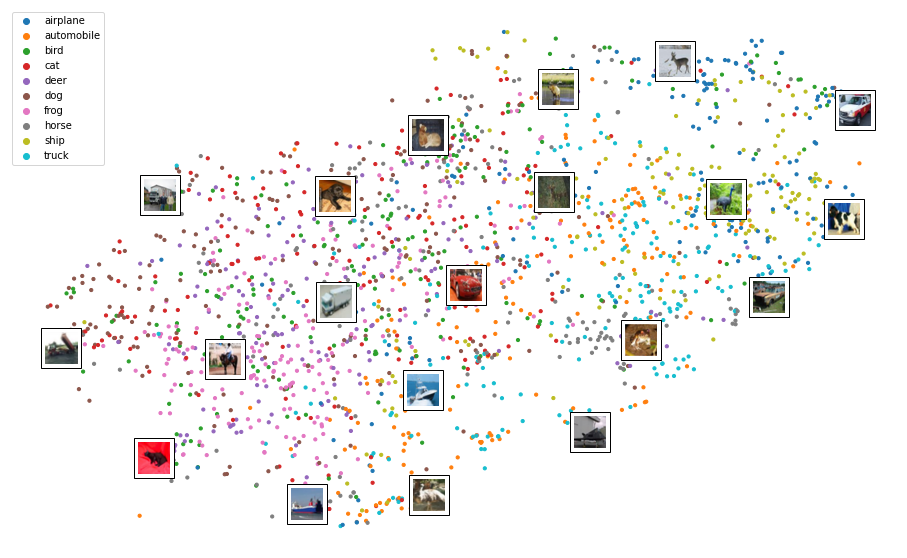

In [49]:
cmap = plt.cm.tab10
plt.figure(figsize=(16,10))
# scatter = plt.scatter(tsne_results_01[:,0],tsne_results_01[:,1], c=y_valid_split[:3250], s=10, cmap=cmap)
scatter = plt.scatter(tsne_results_01[:,0],tsne_results_01[:,1], c=y_valid_split[:2000], s=10, cmap=cmap)
plt.legend(handles=scatter.legend_elements()[0], labels=class_names)

image_positions = np.array([[1., 1.]])
for index, position in enumerate(tsne_results_01):
    dist = np.sum((position - image_positions) ** 2, axis=1)
    if np.min(dist) > 0.02: # if far enough from other images
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(x_train[index], cmap="binary"),
            position, bboxprops={"lw": 1})
        plt.gca().add_artist(imagebox)
plt.axis("off")
plt.show()

## Experiment 2

- DNN with 3 layers
- no regularization

In [32]:
k.clear_session()
model_02 = Sequential([
  Flatten(input_shape=x_train_norm.shape[1:]),
  Dense(units=384,activation=tf.nn.relu),
  Dense(units=768,activation=tf.nn.relu),
  Dense(units=1536,activation=tf.nn.relu),
  Dense(units=10, activation=tf.nn.softmax)       
])

In [33]:
model_02.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 3072)              0         
                                                                 
 dense (Dense)               (None, 384)               1180032   
                                                                 
 dense_1 (Dense)             (None, 768)               295680    
                                                                 
 dense_2 (Dense)             (None, 1536)              1181184   
                                                                 
 dense_3 (Dense)             (None, 10)                15370     
                                                                 
Total params: 2,672,266
Trainable params: 2,672,266
Non-trainable params: 0
_________________________________________________________________


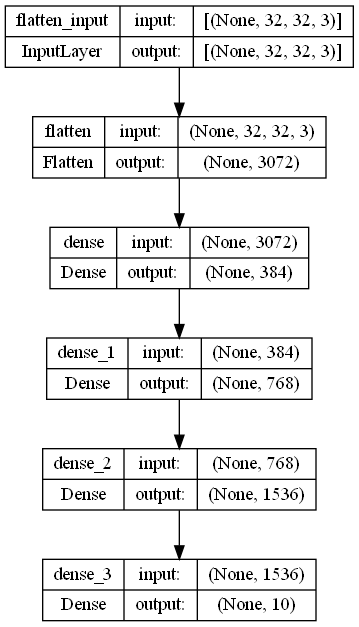

In [34]:
keras.utils.plot_model(model_02, "CIFAR10_EXP_02.png", show_shapes=True) 

In [35]:
model_02.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [36]:
history_02 = model_02.fit(x_train_norm
                    ,y_train_split
                    ,epochs=200
                    ,batch_size=64
                    ,verbose=1
                    ,validation_data=(x_valid_norm, y_valid_split)
                    ,callbacks=[
                     tf.keras.callbacks.ModelCheckpoint("A2_Exp_02_3DNN.h5",save_best_only=True,save_weights_only=False) 
                     ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10),
                    ]                                                                                                           
                   )

Epoch 1/200
704/704 [==============================] - 4s 5ms/step - loss: 1.8555 - accuracy: 0.3269 - val_loss: 1.7618 - val_accuracy: 0.3646
Epoch 2/200
704/704 [==============================] - 4s 5ms/step - loss: 1.6823 - accuracy: 0.3962 - val_loss: 1.6588 - val_accuracy: 0.4048
Epoch 3/200
704/704 [==============================] - 3s 5ms/step - loss: 1.6076 - accuracy: 0.4212 - val_loss: 1.7147 - val_accuracy: 0.4020
Epoch 4/200
704/704 [==============================] - 3s 5ms/step - loss: 1.5412 - accuracy: 0.4441 - val_loss: 1.5692 - val_accuracy: 0.4332
Epoch 5/200
704/704 [==============================] - 4s 5ms/step - loss: 1.4918 - accuracy: 0.4629 - val_loss: 1.5516 - val_accuracy: 0.4546
Epoch 6/200
704/704 [==============================] - 4s 5ms/step - loss: 1.4515 - accuracy: 0.4790 - val_loss: 1.5281 - val_accuracy: 0.4512
Epoch 7/200
704/704 [==============================] - 4s 5ms/step - loss: 1.4160 - accuracy: 0.4880 - val_loss: 1.5319 - val_accuracy: 0.4514

In [38]:
model_02 = tf.keras.models.load_model("A2_Exp_02_3DNN.h5")
print(f"Test acc: {model_02.evaluate(x_test_norm, y_test)[1]:.3f}")

313/313 [==============================] - 1s 4ms/step - loss: 1.4526 - accuracy: 0.4891
Test acc: 0.489


In [50]:
pred02 = model_02.predict(x_test_norm)
print('shape of preds: ', pred02.shape)

313/313 [==============================] - 1s 2ms/step
shape of preds:  (10000, 10)


In [51]:
history_02_dict = history_02.history
history_02_df=pd.DataFrame(history_02_dict)
history_02_df.tail().round(3)

,loss,accuracy,val_loss,val_accuracy
19,0.749,0.727,1.938,0.476
20,0.689,0.749,2.101,0.468
21,0.629,0.771,2.248,0.449
22,0.576,0.792,2.432,0.455
23,0.522,0.812,2.603,0.463


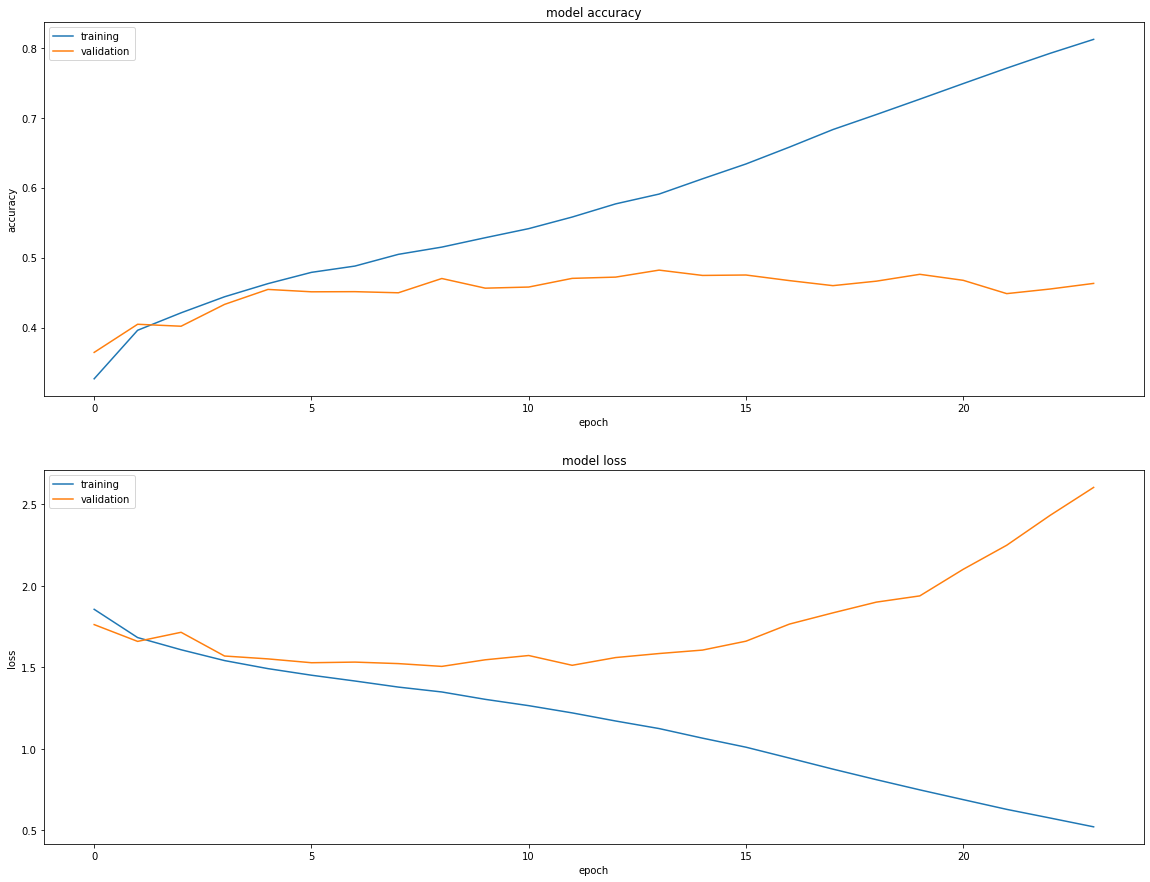

In [52]:
plt.subplots(figsize=(16,12))
plt.tight_layout()
display_training_curves(history_02.history['accuracy'], history_02.history['val_accuracy'], 'accuracy', 211)
display_training_curves(history_02.history['loss'], history_02.history['val_loss'], 'loss', 212)

In [53]:
pred02_cm=np.argmax(pred02, axis=1)
print_validation_report(y_test, pred02_cm)

Classification Report
              precision    recall  f1-score   support

           0       0.50      0.59      0.54      1000
           1       0.66      0.57      0.61      1000
           2       0.32      0.43      0.37      1000
           3       0.33      0.37      0.35      1000
           4       0.44      0.37      0.40      1000
           5       0.48      0.29      0.36      1000
           6       0.47      0.63      0.54      1000
           7       0.59      0.50      0.54      1000
           8       0.63      0.63      0.63      1000
           9       0.64      0.49      0.55      1000

    accuracy                           0.49     10000
   macro avg       0.50      0.49      0.49     10000
weighted avg       0.50      0.49      0.49     10000

Accuracy Score: 0.4891
Root Mean Square Error: 3.035144148141897


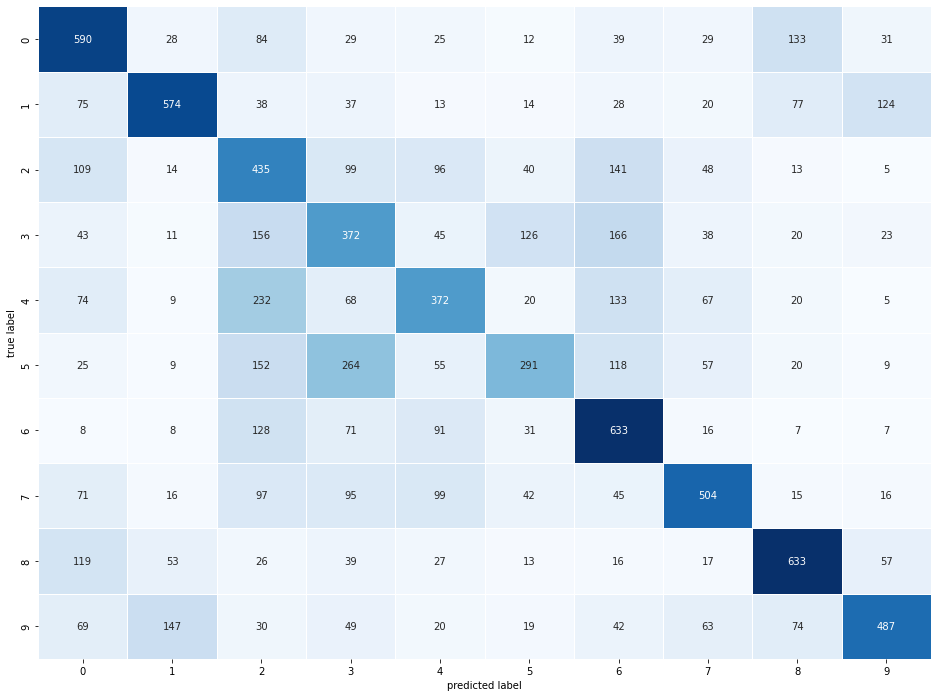

In [54]:
plot_confusion_matrix(y_test,pred02_cm)

In [55]:
cm = sns.light_palette((260, 75, 60), input="husl", as_cmap=True)
df = pd.DataFrame(pred02[0:20], columns = ['airplane'
                                          ,'automobile'
                                          ,'bird'
                                          ,'cat'
                                          ,'deer'
                                          ,'dog'
                                          ,'frog'
                                          ,'horse'
                                          ,'ship'
                                          ,'truck'])
df.style.format("{:.2%}").background_gradient(cmap=cm)

,airplane,automobile,bird,cat,deer,dog,frog,horse,ship,truck
0,1.43%,2.19%,4.14%,27.58%,19.78%,31.72%,3.18%,1.78%,6.42%,1.77%
1,6.41%,17.32%,0.66%,0.13%,0.08%,0.02%,0.02%,0.05%,32.41%,42.90%
2,18.96%,21.71%,3.42%,0.63%,1.00%,0.47%,0.02%,1.06%,26.09%,26.65%
3,30.30%,5.17%,9.83%,3.15%,8.73%,1.20%,0.12%,7.37%,24.24%,9.87%
4,0.17%,0.01%,8.93%,2.08%,72.52%,1.05%,15.03%,0.20%,0.02%,0.01%
5,1.09%,0.03%,2.09%,2.42%,1.95%,0.71%,91.53%,0.08%,0.07%,0.03%
6,6.17%,39.90%,1.95%,10.14%,2.12%,28.62%,2.05%,3.11%,1.85%,4.09%
7,1.70%,0.68%,18.76%,15.03%,14.54%,8.91%,38.38%,0.84%,0.55%,0.62%
8,18.58%,0.19%,46.24%,5.86%,12.61%,7.93%,1.22%,6.82%,0.32%,0.22%
9,4.90%,52.93%,2.79%,8.20%,0.24%,0.95%,0.61%,0.24%,23.37%,5.77%


In [56]:
# Extracts the outputs of the top 8 layers:
layer_outputs = [layer.output for layer in model_02.layers[:8]]
# Creates a model that will return these outputs, given the model input:
activation_model_02 = tf.keras.models.Model(inputs=model_02.input, outputs=layer_outputs)

# Get activation values for the last dense layer
# activations_02 = activation_model_02.predict(x_valid_norm[:3250])
activations_02 = activation_model_02.predict(x_valid_norm[:2000])
dense_layer_activations_02 = activations_02[-3]
output_layer_activations_02 = activations_02[-1]

63/63 [==============================] - 0s 2ms/step


In [57]:
# Reduce the dimension using T-SNE to visualize i n a scatterplot
tsne_02 = TSNE(n_components=2, verbose=1, init='pca', learning_rate='auto', perplexity=40, n_iter=300)
tsne_results_02 = tsne_02.fit_transform(dense_layer_activations_02)

# Scaling
tsne_results_02 = (tsne_results_02 - tsne_results_02.min()) / (tsne_results_02.max() - tsne_results_02.min())

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2000 samples in 0.002s...
[t-SNE] Computed neighbors for 2000 samples in 0.141s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 1.949521


C:\Users\Reed\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 71.608246
[t-SNE] KL divergence after 300 iterations: 2.254985


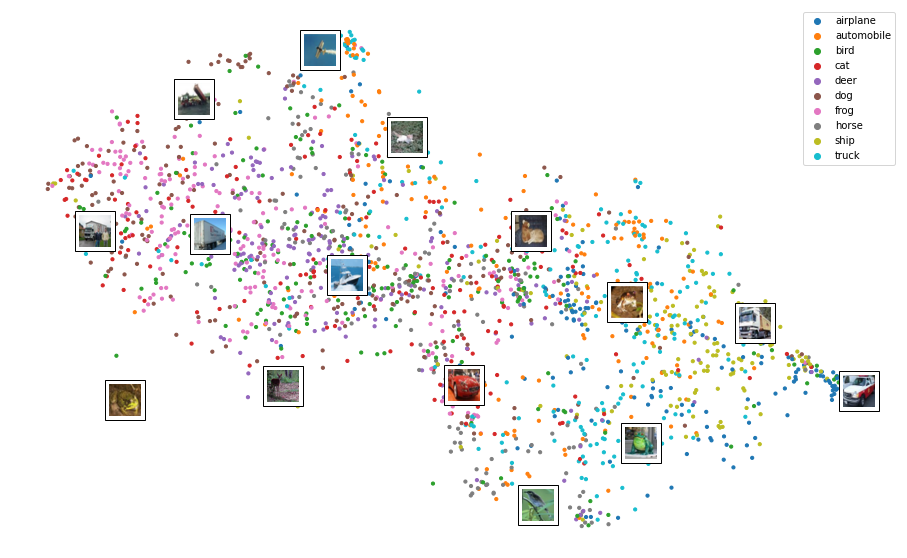

In [58]:
cmap = plt.cm.tab10
plt.figure(figsize=(16,10))
# scatter = plt.scatter(tsne_results_02[:,0],tsne_results_02[:,1], c=y_valid_split[:3250], s=10, cmap=cmap)
scatter = plt.scatter(tsne_results_02[:,0],tsne_results_02[:,1], c=y_valid_split[:2000], s=10, cmap=cmap)
plt.legend(handles=scatter.legend_elements()[0], labels=class_names)

image_positions = np.array([[1., 1.]])
for index, position in enumerate(tsne_results_02):
    dist = np.sum((position - image_positions) ** 2, axis=1)
    if np.min(dist) > 0.02: # if far enough from other images
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(x_train[index], cmap="binary"),
            position, bboxprops={"lw": 1})
        plt.gca().add_artist(imagebox)
plt.axis("off")
plt.show()

## Experiment 3

- CNN with 2 layers/max pooling layers
- 1 full-connected layer
- no regularization

In [56]:
k.clear_session()
model_03 = Sequential([
  Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu,input_shape=x_train_norm.shape[1:]),
  MaxPool2D((2, 2),strides=2),
  Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu),
  MaxPool2D((2, 2),strides=2),
  Flatten(),
  Dense(units=384,activation=tf.nn.relu),
  Dense(units=10, activation=tf.nn.softmax)       
])

In [57]:
model_03.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 128)       3584      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 128)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 256)       295168    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 256)        0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 9216)              0         
                                                                 
 dense (Dense)               (None, 384)               3

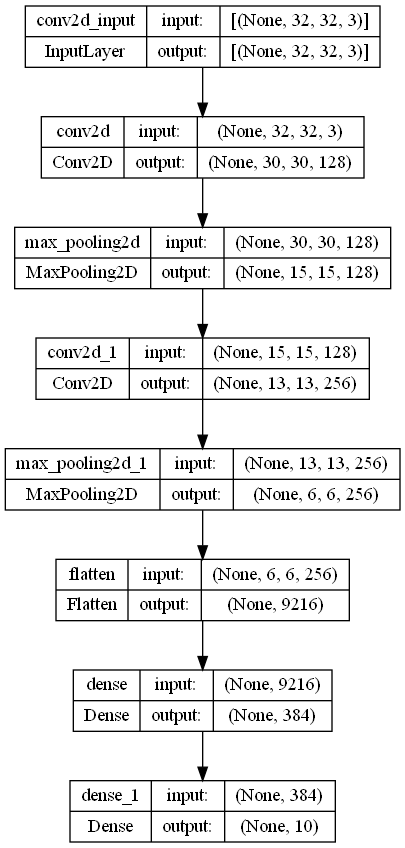

In [58]:
keras.utils.plot_model(model_03, "CIFAR10_EXP_03.png", show_shapes=True) 

In [59]:
model_03.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [60]:
history_03 = model_03.fit(x_train_norm
                    ,y_train_split
                    ,epochs=200
                    ,batch_size=64
                    ,verbose=1
                    ,validation_data=(x_valid_norm, y_valid_split)
                    ,callbacks=[
                     tf.keras.callbacks.ModelCheckpoint("A2_Exp_03_2CNN_2DNN.h5",save_best_only=True,save_weights_only=False) 
                     ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10),
                    ]                                                                                                           
                   )

Epoch 1/200
704/704 [==============================] - 10s 9ms/step - loss: 1.4437 - accuracy: 0.4828 - val_loss: 1.3153 - val_accuracy: 0.5320
Epoch 2/200
704/704 [==============================] - 5s 8ms/step - loss: 1.0583 - accuracy: 0.6306 - val_loss: 1.0442 - val_accuracy: 0.6278
Epoch 3/200
704/704 [==============================] - 6s 8ms/step - loss: 0.8958 - accuracy: 0.6892 - val_loss: 0.9661 - val_accuracy: 0.6640
Epoch 4/200
704/704 [==============================] - 6s 8ms/step - loss: 0.7773 - accuracy: 0.7301 - val_loss: 0.9429 - val_accuracy: 0.6744
Epoch 5/200
704/704 [==============================] - 6s 8ms/step - loss: 0.6732 - accuracy: 0.7676 - val_loss: 0.8645 - val_accuracy: 0.7048
Epoch 6/200
704/704 [==============================] - 5s 8ms/step - loss: 0.5747 - accuracy: 0.8000 - val_loss: 0.8681 - val_accuracy: 0.7052
Epoch 7/200
704/704 [==============================] - 5s 8ms/step - loss: 0.4820 - accuracy: 0.8328 - val_loss: 0.9050 - val_accuracy: 0.708

In [35]:
model_03 = tf.keras.models.load_model("A2_Exp_03_2CNN_2DNN.h5")
print(f"Test acc: {model_03.evaluate(x_test_norm, y_test)[1]:.3f}")

313/313 [==============================] - 2s 4ms/step - loss: 0.8573 - accuracy: 0.7089
Test acc: 0.709


In [36]:
pred03 = model_03.predict(x_test_norm)
print('shape of preds: ', pred03.shape)

313/313 [==============================] - 1s 3ms/step
shape of preds:  (10000, 10)


In [63]:
history_03_dict = history_03.history
history_03_df=pd.DataFrame(history_03_dict)
history_03_df.tail().round(3)

,loss,accuracy,val_loss,val_accuracy
14,0.092,0.969,1.827,0.694
15,0.088,0.969,1.825,0.696
16,0.080,0.972,1.906,0.706
17,0.055,0.982,2.098,0.692
18,0.072,0.975,2.175,0.686


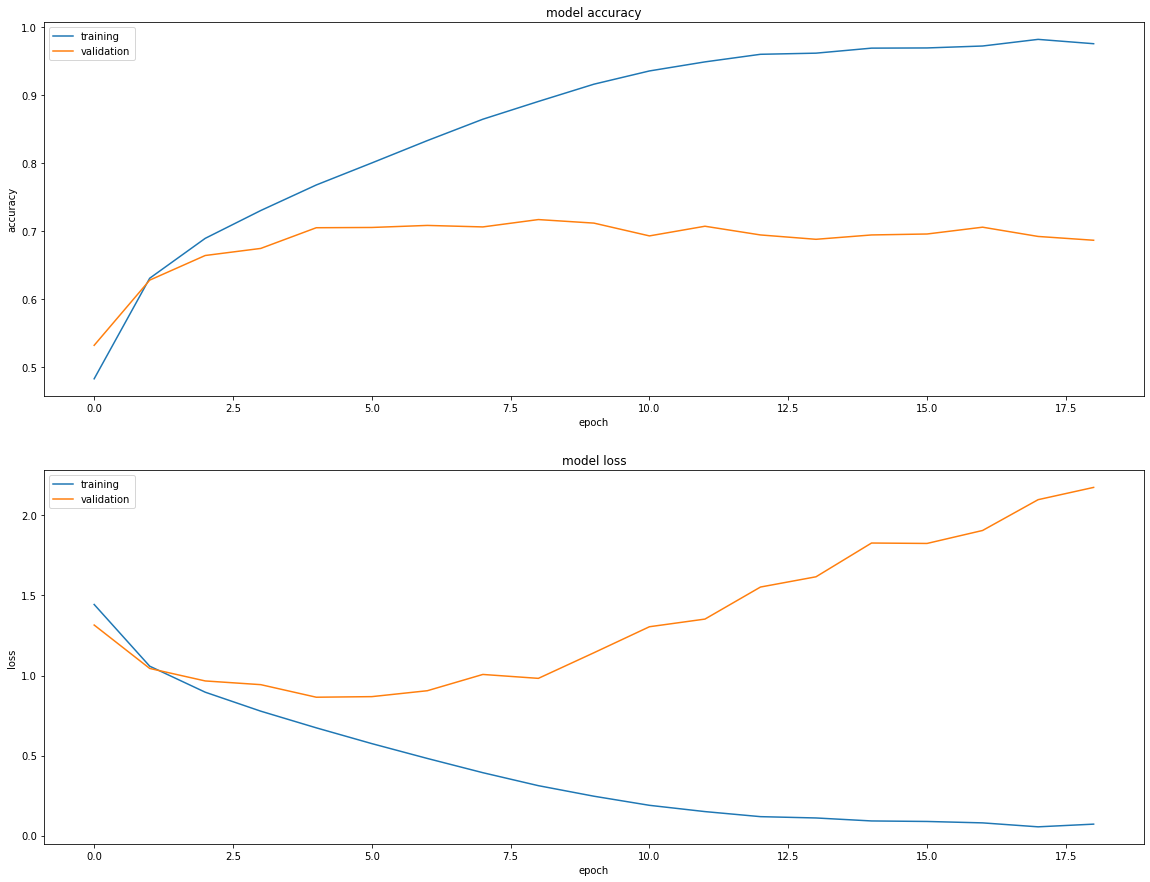

In [64]:
plt.subplots(figsize=(16,12))
plt.tight_layout()
display_training_curves(history_03.history['accuracy'], history_03.history['val_accuracy'], 'accuracy', 211)
display_training_curves(history_03.history['loss'], history_03.history['val_loss'], 'loss', 212)

In [37]:
pred03_cm=np.argmax(pred03, axis=1)
print_validation_report(y_test, pred03_cm)

Classification Report
              precision    recall  f1-score   support

           0       0.80      0.73      0.76      1000
           1       0.81      0.84      0.83      1000
           2       0.59      0.63      0.61      1000
           3       0.60      0.44      0.51      1000
           4       0.64      0.68      0.66      1000
           5       0.65      0.58      0.62      1000
           6       0.67      0.86      0.76      1000
           7       0.84      0.67      0.75      1000
           8       0.73      0.87      0.79      1000
           9       0.76      0.79      0.77      1000

    accuracy                           0.71     10000
   macro avg       0.71      0.71      0.70     10000
weighted avg       0.71      0.71      0.70     10000

Accuracy Score: 0.7089
Root Mean Square Error: 2.2537524265100637


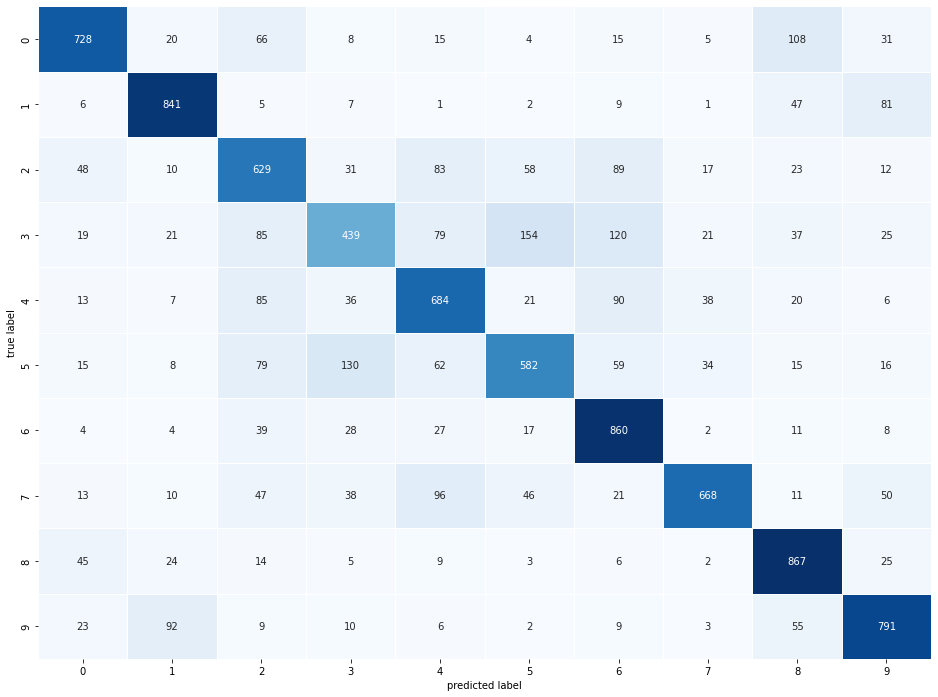

In [38]:
plot_confusion_matrix(y_test,pred03_cm)

In [39]:
cm = sns.light_palette((260, 75, 60), input="husl", as_cmap=True)
df = pd.DataFrame(pred03[0:20], columns = ['airplane'
                                          ,'automobile'
                                          ,'bird'
                                          ,'cat'
                                          ,'deer'
                                          ,'dog'
                                          ,'frog'
                                          ,'horse'
                                          ,'ship'
                                          ,'truck'])
df.style.format("{:.2%}").background_gradient(cmap=cm)

,airplane,automobile,bird,cat,deer,dog,frog,horse,ship,truck
0,0.43%,1.60%,1.20%,78.25%,0.25%,15.39%,1.47%,0.07%,1.10%,0.24%
1,0.02%,5.68%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,94.27%,0.02%
2,1.53%,29.27%,0.06%,0.11%,0.04%,0.00%,0.02%,0.03%,68.29%,0.64%
3,45.99%,3.77%,0.34%,0.12%,0.53%,0.00%,0.05%,0.01%,49.14%,0.05%
4,0.00%,0.00%,0.73%,4.89%,68.46%,0.50%,25.41%,0.00%,0.00%,0.00%
5,0.00%,0.01%,0.74%,0.23%,0.21%,0.50%,98.17%,0.01%,0.10%,0.02%
6,0.08%,81.07%,0.02%,0.36%,0.00%,0.04%,0.43%,0.02%,0.01%,17.97%
7,0.20%,0.01%,31.43%,1.51%,13.79%,0.47%,52.29%,0.12%,0.13%,0.05%
8,0.23%,0.04%,2.56%,81.88%,4.47%,6.11%,3.92%,0.58%,0.09%,0.13%
9,0.02%,97.27%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.38%,2.32%


In [40]:
layer_names = []
for layer in model_03.layers:
    layer_names.append(layer.name)
    
layer_names

['conv2d',
 'max_pooling2d',
 'conv2d_1',
 'max_pooling2d_1',
 'flatten',
 'dense',
 'dense_1']

In [49]:
# Extracts the outputs of the top 8 layers:
layer_outputs_03 = [layer.output for layer in model_03.layers[:7]]
# Creates a model that will return these outputs, given the model input:
activation_model_03 = tf.keras.models.Model(inputs=model_03.input, outputs=layer_outputs_03)

# Get activation values for the last dense layer
# activations_03 = activation_model_03.predict(x_valid_norm[:3250])
activations_03 = activation_model_03.predict(x_valid_norm[:1000])
dense_layer_activations_03 = activations_03[-3]
output_layer_activations_03 = activations_03[-1]

32/32 [==============================] - 0s 10ms/step


In [50]:
dense_layer_activations_03.shape

(1000, 9216)

In [51]:
# Reduce the dimension using T-SNE to visualize i n a scatterplot
tsne_03 = TSNE(n_components=2, verbose=1, init='pca', learning_rate='auto', perplexity=40, n_iter=300)
tsne_results_03 = tsne_03.fit_transform(dense_layer_activations_03)

# Scaling
tsne_results_03 = (tsne_results_03 - tsne_results_03.min()) / (tsne_results_03.max() - tsne_results_03.min())

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.007s...
[t-SNE] Computed neighbors for 1000 samples in 0.336s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 2.273556


C:\Users\Reed\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 71.004417
[t-SNE] KL divergence after 300 iterations: 1.907394


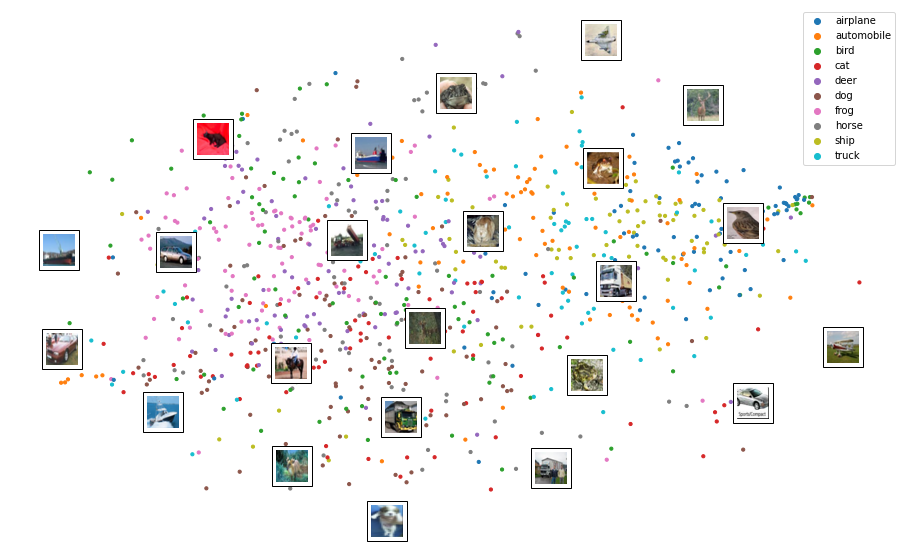

In [52]:
cmap = plt.cm.tab10
plt.figure(figsize=(16,10))
# scatter = plt.scatter(tsne_results_03[:,0],tsne_results_03[:,1], c=y_valid_split[:3250], s=10, cmap=cmap)
scatter = plt.scatter(tsne_results_03[:,0],tsne_results_03[:,1], c=y_valid_split[:1000], s=10, cmap=cmap)
plt.legend(handles=scatter.legend_elements()[0], labels=class_names)

image_positions = np.array([[1., 1.]])
for index, position in enumerate(tsne_results_03):
    dist = np.sum((position - image_positions) ** 2, axis=1)
    if np.min(dist) > 0.02: # if far enough from other images
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(x_train[index], cmap="binary"),
            position, bboxprops={"lw": 1})
        plt.gca().add_artist(imagebox)
plt.axis("off")
plt.show()

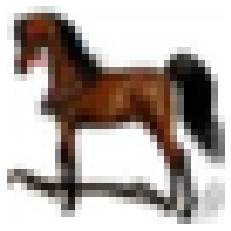

In [45]:
(_,_), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()

img = test_images[2004]
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)

class_names = ['airplane'
,'automobile'
,'bird'
,'cat'
,'deer'
,'dog'
,'frog' 
,'horse'
,'ship'
,'truck']

plt.imshow(img, cmap='viridis')
plt.axis('off')
plt.show()

In [46]:
activations_cnn_03 = activation_model_03.predict(img_tensor)
len(activations_cnn_03)

1/1 [==============================] - 0s 178ms/step


7

In [47]:
layer_names = []
for layer in model_03.layers:
    layer_names.append(layer.name)
    
layer_names

['conv2d',
 'max_pooling2d',
 'conv2d_1',
 'max_pooling2d_1',
 'flatten',
 'dense',
 'dense_1']

C:\Users\Reed\AppData\Local\Temp\ipykernel_148\957070418.py:28: RuntimeWarning: invalid value encountered in true_divide
  channel_image /= channel_image.std()


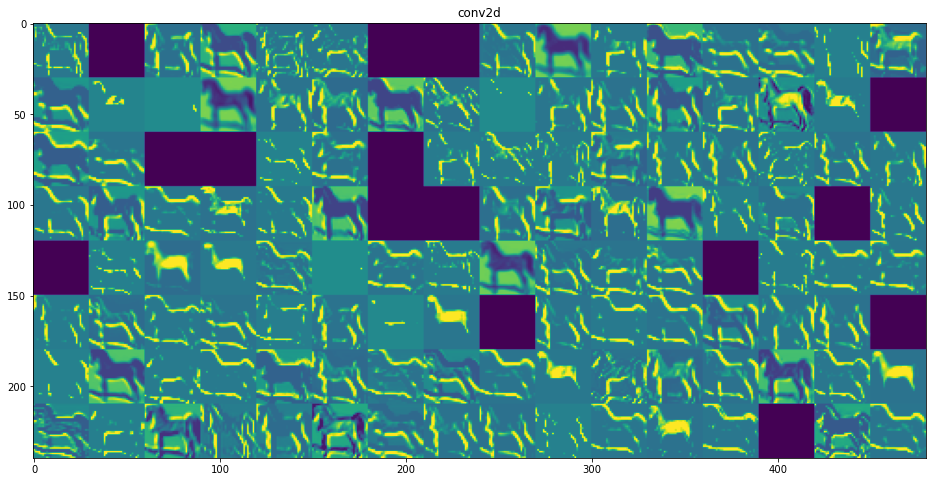

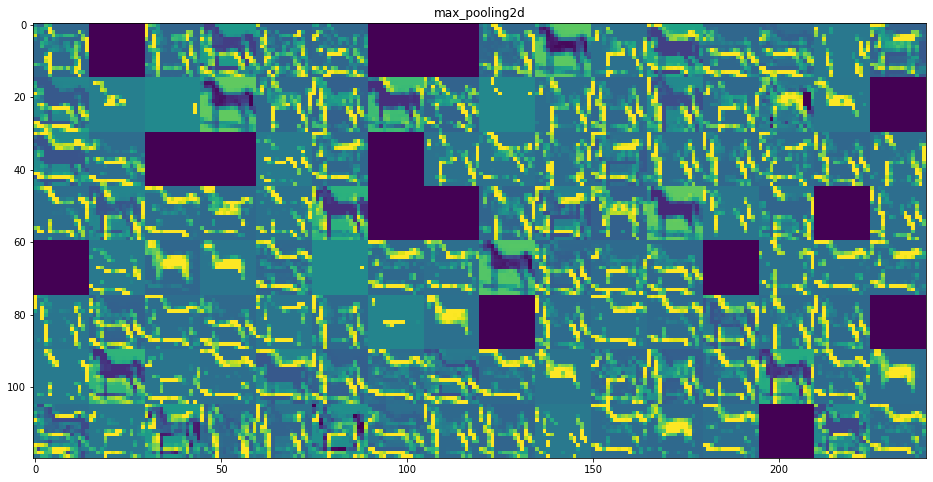

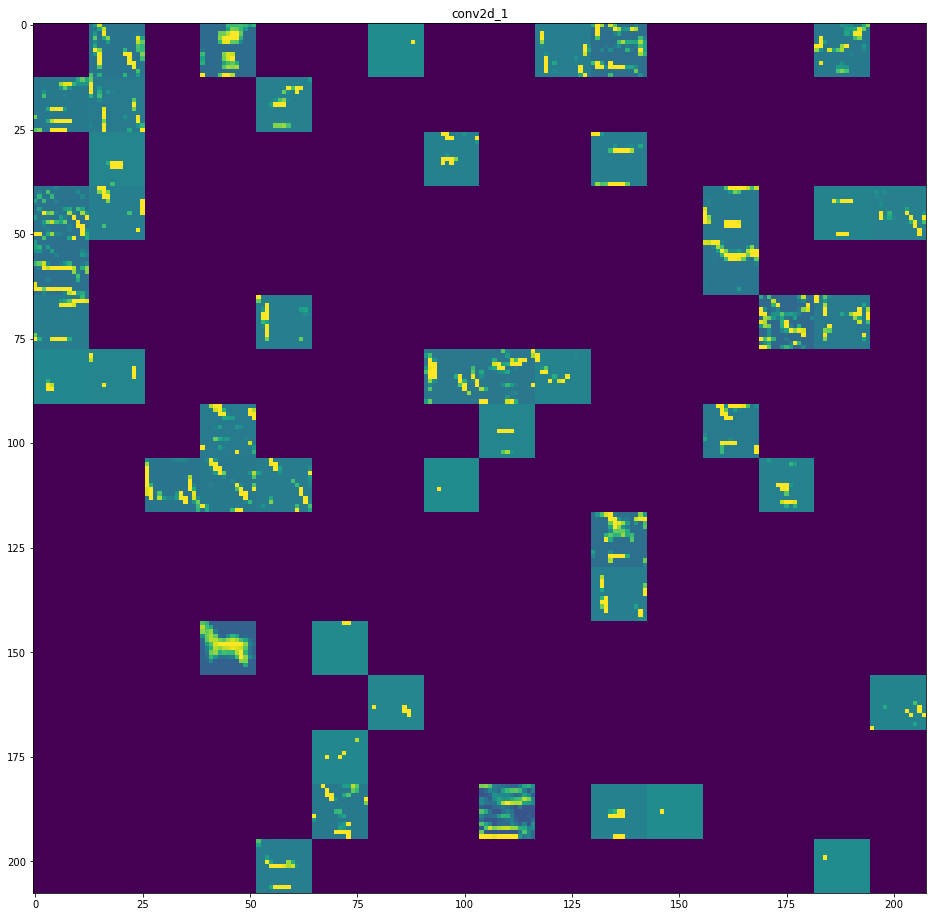

In [48]:
# These are the names of the layers, so can have them as part of our plot
layer_names = []
for layer in model_03.layers[:3]:
    layer_names.append(layer.name)

images_per_row = 16

# Now let's display our feature maps
for layer_name, layer_activation in zip(layer_names, activations_cnn_03):
    # This is the number of features in the feature map
    n_features = layer_activation.shape[-1]

    # The feature map has shape (1, size, size, n_features)
    size = layer_activation.shape[1]

    # We will tile the activation channels in this matrix
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))

    # We'll tile each filter into this big horizontal grid
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            # Post-process the feature to make it visually palatable
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size,
                         row * size : (row + 1) * size] = channel_image

    # Display the grid
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')
    
plt.show();

## Experiment 4

- CNN with 3 layers/max pooling layers
- 1 fully-connected layer
- no regularization

In [77]:
k.clear_session()
model_04 = Sequential([
  Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu,input_shape=x_train_norm.shape[1:]),
  MaxPool2D((2, 2),strides=2),
  Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu),
  MaxPool2D((2, 2),strides=2),
  Conv2D(filters=512, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu),
  MaxPool2D((2, 2),strides=2),
  Flatten(),
  Dense(units=384,activation=tf.nn.relu),
  Dense(units=10, activation=tf.nn.softmax)       
])

In [78]:
model_04.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 128)       3584      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 128)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 256)       295168    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 256)        0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 512)         1180160   
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 2, 2, 512)        0

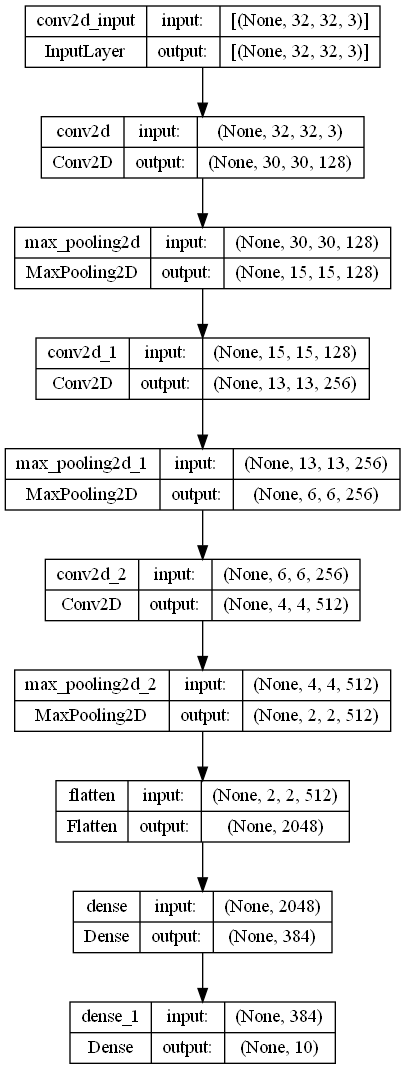

In [79]:
keras.utils.plot_model(model_04, "CIFAR10_EXP_04.png", show_shapes=True) 

In [80]:
model_04.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [81]:
history_04 = model_04.fit(x_train_norm
                    ,y_train_split
                    ,epochs=200
                    ,batch_size=64
                    ,verbose=1
                    ,validation_data=(x_valid_norm, y_valid_split)
                    ,callbacks=[
                     tf.keras.callbacks.ModelCheckpoint("A2_Exp_04_3CNN.h5",save_best_only=True,save_weights_only=False) 
                     ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10),
                    ]                                                                                                           
                   )

Epoch 1/200
704/704 [==============================] - 8s 10ms/step - loss: 1.5276 - accuracy: 0.4403 - val_loss: 1.3245 - val_accuracy: 0.5286
Epoch 2/200
704/704 [==============================] - 7s 9ms/step - loss: 1.0924 - accuracy: 0.6147 - val_loss: 1.0118 - val_accuracy: 0.6362
Epoch 3/200
704/704 [==============================] - 7s 9ms/step - loss: 0.8944 - accuracy: 0.6886 - val_loss: 0.9734 - val_accuracy: 0.6490
Epoch 4/200
704/704 [==============================] - 7s 10ms/step - loss: 0.7628 - accuracy: 0.7362 - val_loss: 0.8589 - val_accuracy: 0.7016
Epoch 5/200
704/704 [==============================] - 7s 10ms/step - loss: 0.6532 - accuracy: 0.7728 - val_loss: 0.8071 - val_accuracy: 0.7242
Epoch 6/200
704/704 [==============================] - 6s 9ms/step - loss: 0.5576 - accuracy: 0.8044 - val_loss: 0.8500 - val_accuracy: 0.7174
Epoch 7/200
704/704 [==============================] - 6s 9ms/step - loss: 0.4714 - accuracy: 0.8356 - val_loss: 0.8131 - val_accuracy: 0.7

In [82]:
model_04 = tf.keras.models.load_model("A2_Exp_04_3CNN.h5")
print(f"Test acc: {model_04.evaluate(x_test_norm, y_test)[1]:.3f}")

313/313 [==============================] - 1s 4ms/step - loss: 0.8015 - accuracy: 0.7235
Test acc: 0.724


In [83]:
pred04 = model_04.predict(x_test_norm)
print('shape of preds: ', pred04.shape)

313/313 [==============================] - 1s 2ms/step
shape of preds:  (10000, 10)


In [84]:
history_04_dict = history_04.history
history_04_df=pd.DataFrame(history_04_dict)
history_04_df.tail().round(3)

,loss,accuracy,val_loss,val_accuracy
12,0.154,0.945,1.321,0.719
13,0.132,0.953,1.446,0.714
14,0.127,0.955,1.386,0.721
15,0.111,0.961,1.466,0.725
16,0.095,0.967,1.605,0.711


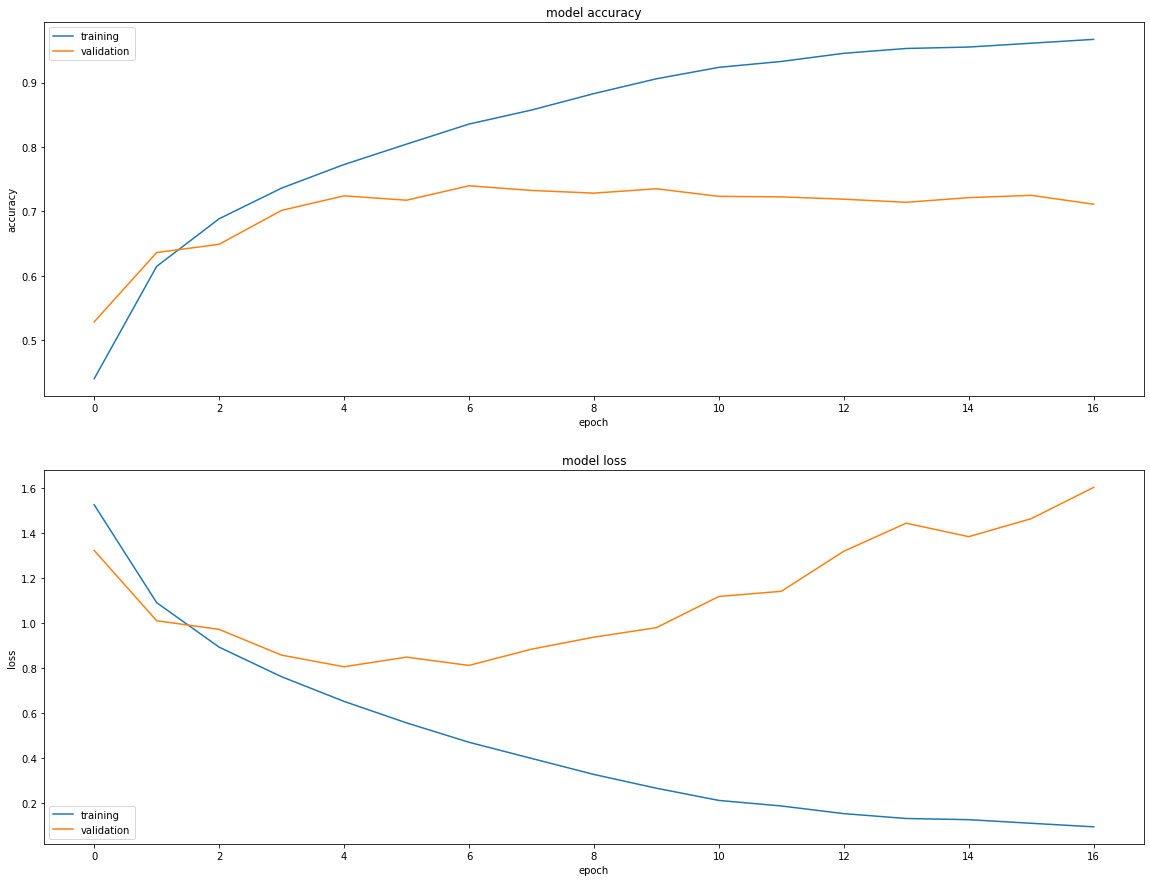

In [85]:
plt.subplots(figsize=(16,12))
plt.tight_layout()
display_training_curves(history_04.history['accuracy'], history_04.history['val_accuracy'], 'accuracy', 211)
display_training_curves(history_04.history['loss'], history_04.history['val_loss'], 'loss', 212)

In [86]:
pred04_cm=np.argmax(pred04, axis=1)
print_validation_report(y_test, pred04_cm)

Classification Report
              precision    recall  f1-score   support

           0       0.81      0.73      0.77      1000
           1       0.90      0.81      0.85      1000
           2       0.71      0.54      0.61      1000
           3       0.63      0.42      0.50      1000
           4       0.54      0.83      0.66      1000
           5       0.61      0.69      0.65      1000
           6       0.78      0.79      0.79      1000
           7       0.81      0.73      0.76      1000
           8       0.76      0.86      0.81      1000
           9       0.79      0.84      0.82      1000

    accuracy                           0.72     10000
   macro avg       0.73      0.72      0.72     10000
weighted avg       0.73      0.72      0.72     10000

Accuracy Score: 0.7235
Root Mean Square Error: 2.098952119511067


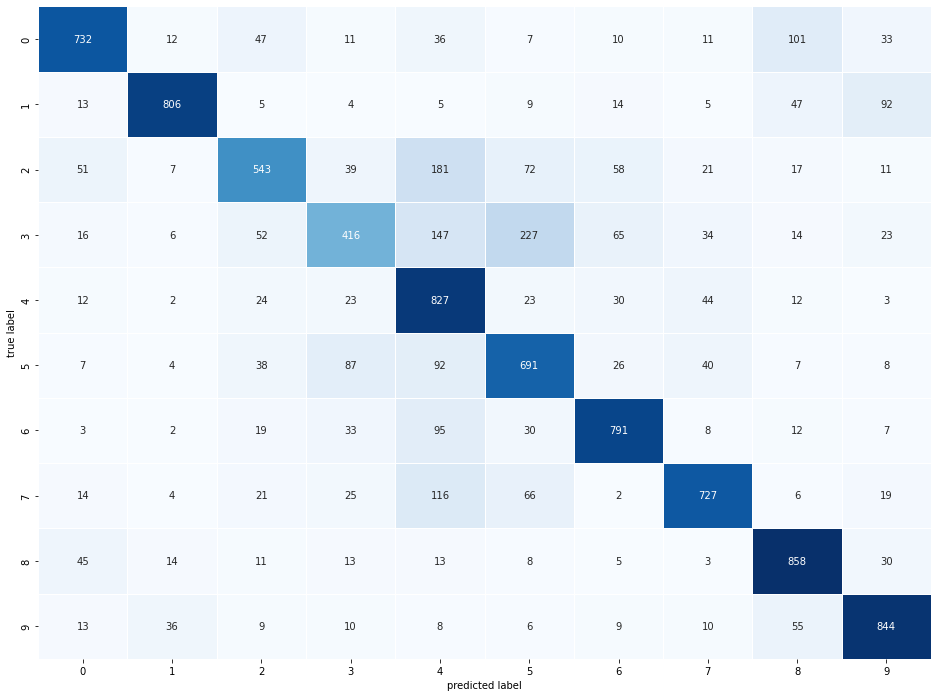

In [87]:
plot_confusion_matrix(y_test,pred04_cm)

In [88]:
cm = sns.light_palette((260, 75, 60), input="husl", as_cmap=True)
df = pd.DataFrame(pred04[0:20], columns = ['airplane'
                                          ,'automobile'
                                          ,'bird'
                                          ,'cat'
                                          ,'deer'
                                          ,'dog'
                                          ,'frog'
                                          ,'horse'
                                          ,'ship'
                                          ,'truck'])
df.style.format("{:.2%}").background_gradient(cmap=cm)

,airplane,automobile,bird,cat,deer,dog,frog,horse,ship,truck
0,0.32%,0.06%,0.57%,61.47%,0.92%,21.79%,6.02%,0.34%,8.48%,0.03%
1,0.26%,1.48%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,98.20%,0.06%
2,4.24%,14.26%,0.26%,0.98%,0.05%,0.11%,0.21%,0.25%,75.18%,4.46%
3,62.38%,3.13%,2.30%,0.10%,7.43%,0.01%,0.05%,0.00%,24.36%,0.23%
4,0.00%,0.00%,0.66%,0.40%,95.01%,0.04%,3.89%,0.00%,0.00%,0.00%
5,0.01%,0.05%,0.28%,1.25%,0.52%,1.56%,96.20%,0.06%,0.02%,0.05%
6,0.10%,32.53%,0.99%,2.62%,0.02%,3.62%,0.18%,0.37%,1.32%,58.25%
7,0.54%,0.01%,8.01%,3.65%,13.09%,0.68%,73.70%,0.05%,0.08%,0.17%
8,0.09%,0.00%,3.95%,44.50%,26.96%,18.36%,4.62%,1.41%,0.03%,0.06%
9,0.18%,77.49%,0.06%,0.01%,0.01%,0.00%,0.22%,0.00%,0.50%,21.52%


In [89]:
layer_names = []
for layer in model_04.layers:
    layer_names.append(layer.name)
    
layer_names

['conv2d',
 'max_pooling2d',
 'conv2d_1',
 'max_pooling2d_1',
 'conv2d_2',
 'max_pooling2d_2',
 'flatten',
 'dense',
 'dense_1']

In [90]:
# Extracts the outputs of the top 11 layers:
layer_outputs_04 = [layer.output for layer in model_04.layers[:13]]
# Creates a model that will return these outputs, given the model input:
activation_model_04 = tf.keras.models.Model(inputs=model_04.input, outputs=layer_outputs_04)

# Get activation values for the last dense layer
# activations_04 = activation_model_04.predict(x_valid_norm[:3250])
activations_04 = activation_model_04.predict(x_valid_norm[:1000])
dense_layer_activations_04 = activations_04[-3]
output_layer_activations_04 = activations_04[-1]

32/32 [==============================] - 0s 2ms/step


In [91]:
activations_04[-3].shape

(1000, 2048)

In [92]:
# Reduce the dimension using T-SNE to visualize i n a scatterplot
tsne_04 = TSNE(n_components=2, verbose=1, init='pca', learning_rate='auto', perplexity=40, n_iter=300)
tsne_results_04 = tsne_04.fit_transform(dense_layer_activations_04)

# Scaling
tsne_results_04 = (tsne_results_04 - tsne_results_04.min()) / (tsne_results_04.max() - tsne_results_04.min())

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.002s...
[t-SNE] Computed neighbors for 1000 samples in 0.072s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 2.057320


C:\Users\Reed\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 63.424397
[t-SNE] KL divergence after 300 iterations: 1.789672


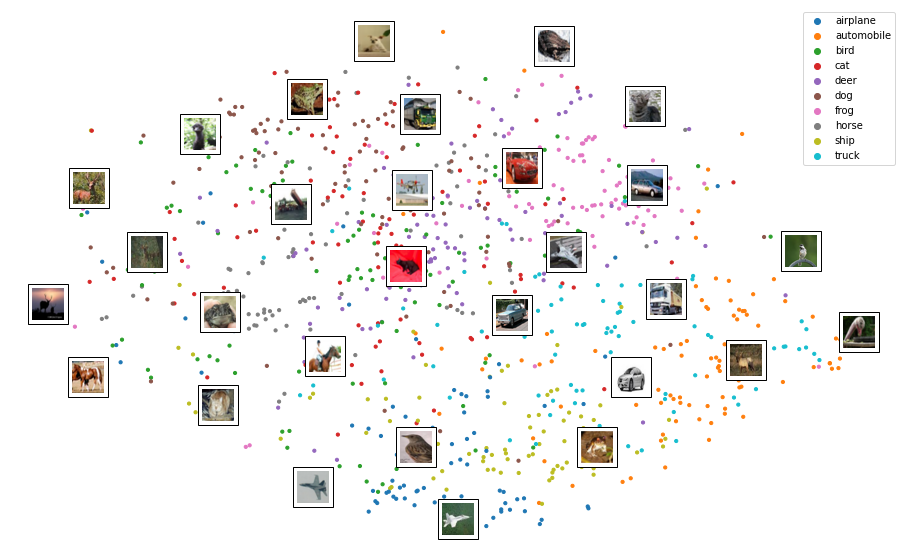

In [93]:
cmap = plt.cm.tab10
plt.figure(figsize=(16,10))
# scatter = plt.scatter(tsne_results_04[:,0],tsne_results_04[:,1], c=y_valid_split[:3250], s=10, cmap=cmap)
scatter = plt.scatter(tsne_results_04[:,0],tsne_results_04[:,1], c=y_valid_split[:1000], s=10, cmap=cmap)
plt.legend(handles=scatter.legend_elements()[0], labels=class_names)

image_positions = np.array([[1., 1.]])
for index, position in enumerate(tsne_results_04):
    dist = np.sum((position - image_positions) ** 2, axis=1)
    if np.min(dist) > 0.02: # if far enough from other images
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(x_train[index], cmap="binary"),
            position, bboxprops={"lw": 1})
        plt.gca().add_artist(imagebox)
plt.axis("off")
plt.show()

In [94]:
# (_,_), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()

# img = test_images[2004]
# img_tensor = image.img_to_array(img)
# img_tensor = np.expand_dims(img_tensor, axis=0)

# class_names = ['airplane'
# ,'automobile'
# ,'bird'
# ,'cat'
# ,'deer'
# ,'dog'
# ,'frog' 
# ,'horse'
# ,'ship'
# ,'truck']

# plt.imshow(img, cmap='viridis')
# plt.axis('off')
# plt.show()

In [95]:
activations_cnn_04 = activation_model_04.predict(img_tensor)
len(activations_cnn_04)

1/1 [==============================] - 0s 86ms/step


9

In [96]:
layer_names = []
for layer in model_04.layers:
    layer_names.append(layer.name)
    
layer_names

['conv2d',
 'max_pooling2d',
 'conv2d_1',
 'max_pooling2d_1',
 'conv2d_2',
 'max_pooling2d_2',
 'flatten',
 'dense',
 'dense_1']

C:\Users\Reed\AppData\Local\Temp\ipykernel_28944\3378183839.py:28: RuntimeWarning: invalid value encountered in true_divide
  channel_image /= channel_image.std()


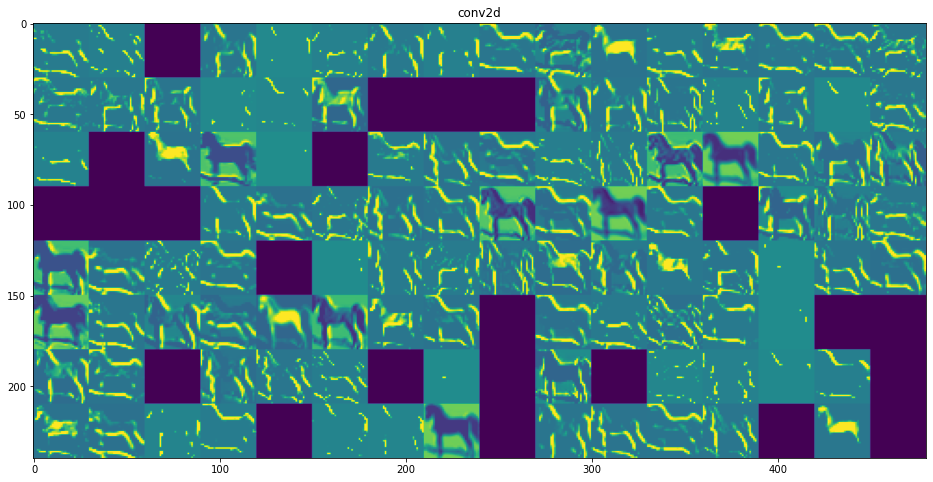

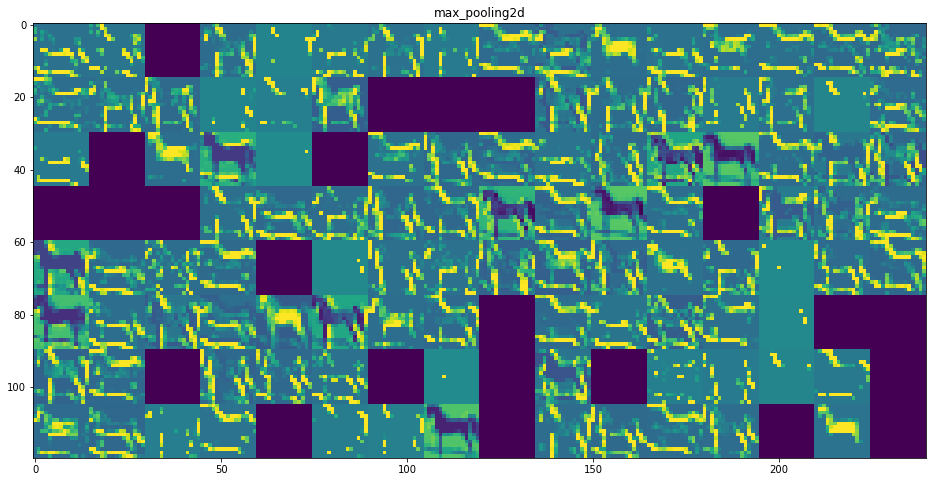

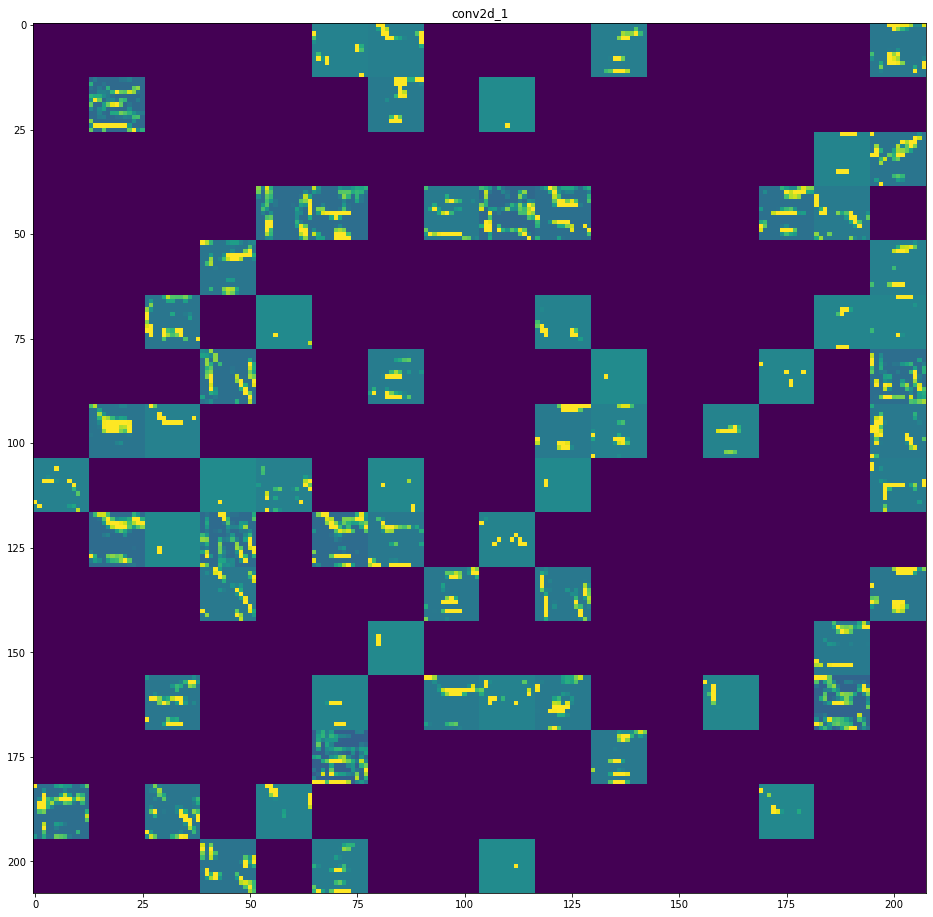

In [97]:
# These are the names of the layers, so can have them as part of our plot
layer_names = []
for layer in model_04.layers[:3]:
    layer_names.append(layer.name)

images_per_row = 16

# Now let's display our feature maps
for layer_name, layer_activation in zip(layer_names, activations_cnn_04):
    # This is the number of features in the feature map
    n_features = layer_activation.shape[-1]

    # The feature map has shape (1, size, size, n_features)
    size = layer_activation.shape[1]

    # We will tile the activation channels in this matrix
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))

    # We'll tile each filter into this big horizontal grid
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            # Post-process the feature to make it visually palatable
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size,
                         row * size : (row + 1) * size] = channel_image

    # Display the grid
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')
    
plt.show();